### DESCRIPTION
    In this notebook, there're two functions wich executed at a specific time interval.
    Function "handling_messages" gets data from PubSub by a subscriber. This function is executed at every PULLING_WAIT_SECONDS seconds and get NUM_MESSAGES messages from PubSub. Data from each message is counted in dataframe "df" in an appropriate time interval, which defined in TIME_WINDOW.
    Function "draw_graph" is executed at every DRAWING_WAIT_SECONDS seconds, get data from "df" and draw a graph with candlesticks. This function uses a value of MAX_CANDLESTICKS_ON_GRAPH to limit a quantity of sticks on the graph.
    
### STEPS:
0. **Installation**\
    This step is necessary in case if a graph in function "draw_graph" isn't showing in JupyterLab notebook.\
    For solving this problem it needs to install some modules.\
    For this, you need to open a terminal (*File\New\Terminal*) and execute such commands:\
    *sudo jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.1 --no-build*\
    *sudo jupyter labextension install plotlywidget@1.5.2 --no-build*\
    *sudo jupyter labextension install jupyterlab-plotly@1.5.2 --no-build*\
    *sudo jupyter lab build*\
    
    You can check installed modules by command:\
    *jupyter labextension list*
1. **Connecting needed modules**
2. **Setting constant**
3. **Definition of function "handling_messages"**
4. **Definition of function "draw_graph"**
5. **Initializing needed variables and starting functions "handling_messages" and "draw_graph"**
6. **Canceling process loop and outputting info**

In [ ]:
# STEP 1

from google.cloud import pubsub_v1
import json
import pandas as pd
import time
import datetime
import plotly.graph_objects as go
import time, threading
from IPython.display import clear_output

In [ ]:
# STEP 2

PROJECT_ID = "streaming-fsi-showcase"
SUBSCRIPTION_NAME = "ethereum.transactions_replay"
NUM_MESSAGES = 1000
PULLING_WAIT_SECONDS = 5
DRAWING_WAIT_SECONDS = 10
TIME_WINDOW = 20 # in seconds
MAX_CANDLESTICKS_ON_GRAPH = 20
PRICE_MULTIPLIER = 1000000000

subscriber = pubsub_v1.SubscriberClient()
subscription_path = subscriber.subscription_path(
    PROJECT_ID, SUBSCRIPTION_NAME
)

In [ ]:
# STEP 3

def handling_messages():
    global NUM_MESSAGES, PULLING_WAIT_SECONDS, df, tr_handling_messages, current_timestamp, last_receiving_datetime, total_received_messages, max_timestamp, error_counter, cancel_process
    
    response = subscriber.pull(subscription_path, max_messages=NUM_MESSAGES)
    
    ack_ids = []
    for received_message in response.received_messages:
        data = json.loads(received_message.message.data.decode('utf8'))
        block_timestamp = data['block_timestamp']
        gas_price = float(data['gas_price'])/PRICE_MULTIPLIER
        
        unix_timestamp = int(time.mktime(datetime.datetime.strptime(block_timestamp, "%Y-%m-%d %H:%M:%S %Z").timetuple()))
        
        if unix_timestamp < max_timestamp:
            continue
        
        if unix_timestamp > max_timestamp:
            max_timestamp = unix_timestamp  
            
        if current_timestamp == 0:
            current_timestamp = max_timestamp = unix_timestamp  
        elif unix_timestamp > current_timestamp+TIME_WINDOW:
            current_timestamp += int((unix_timestamp - current_timestamp)/TIME_WINDOW)*TIME_WINDOW
            
        indexes = df['unix_timestamp'][df['unix_timestamp'] == current_timestamp].index
        if (indexes.size == 0):
            df = df.append({'unix_timestamp': current_timestamp, 'min_price':gas_price, 'max_price':gas_price, 'open_price':gas_price, 'close_price':gas_price}, ignore_index=True)
        else:
            index = indexes[0]
            min_price = min(gas_price, df['min_price'][index])
            max_price = max(gas_price, df['max_price'][index])
            df.loc[[index], 'min_price'] = min_price
            df.loc[[index], 'max_price'] = max_price
            df.loc[[index], 'close_price'] = gas_price

        ack_ids.append(received_message.ack_id)


    try:
        subscriber.acknowledge(subscription_path, ack_ids)
    except Exception as e:
        error_counter += 1

    last_receiving_datetime = datetime.datetime.now()
    total_received_messages += len(response.received_messages)
    
    if not cancel_process:
        tr_handling_messages = threading.Timer(PULLING_WAIT_SECONDS, handling_messages)
        tr_handling_messages.start()


In [8]:
# STEP 4

def draw_graph():
    global DRAWING_WAIT_SECONDS, tr_drawing_graph, df, cancel_process
    
    graph_df = df.tail(MAX_CANDLESTICKS_ON_GRAPH)
    graph_df['date'] = graph_df.apply(lambda row: datetime.datetime.fromtimestamp(row.unix_timestamp), axis = 1)
    
    first_date_on_graph = min(graph_df['date'])
    last_date_on_graph = max(graph_df['date'])
    
    clear_output(wait=True)
    
    fig = go.Figure(data=[go.Candlestick(x=graph_df['date'],
                open=graph_df['open_price'], high=graph_df['max_price'],
                low=graph_df['min_price'], close=graph_df['close_price'])],
                layout=go.Layout(
                    width=1200,
                    height=600,
                ))
    fig.update_layout(
#         xaxis_rangeslider_visible=False,
        title_text="Last receiving messages date: {}<br>Total messages: {}<br>First date on graph: {}<br>Last date on graph: {}".format(last_receiving_datetime.strftime("%Y-%m-%d %H:%M:%S"), total_received_messages, first_date_on_graph, last_date_on_graph),
        font=dict(family="Courier New, monospace", size=8, color="#7f7f7f")
    )
    fig.show()

    if not cancel_process:
        tr_drawing_graph = threading.Timer(DRAWING_WAIT_SECONDS, draw_graph)
        tr_drawing_graph.start()

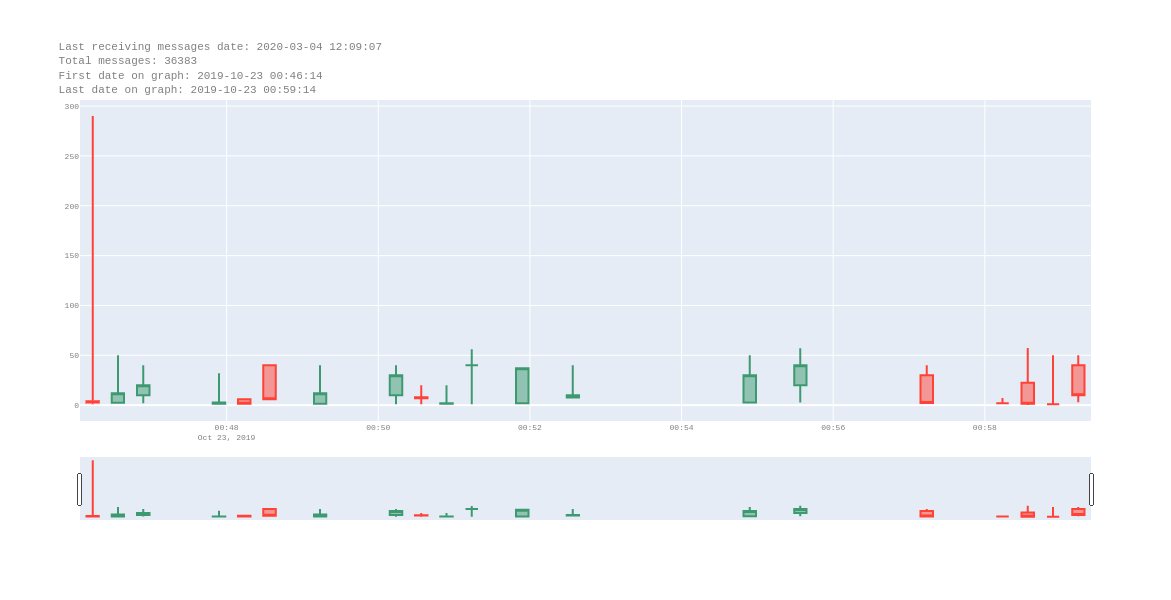

In [9]:
# STEP 5

df = pd.DataFrame(columns = ['unix_timestamp', 'min_price', 'max_price', 'open_price', 'close_price'])

tr_handling_messages = None
last_receiving_datetime = None
total_received_messages = 0
current_timestamp = 0
max_timestamp = 0
receiving_process_running = True

cancel_process = False

error_counter = 0
handling_messages()
draw_graph()

In [ ]:
# STEP 6

cancel_process = True

print("Last date: {}\nTotal messages: {}\n".format(last_receiving_datetime.strftime("%Y-%m-%d %H:%M:%S"), total_received_messages))